In [1]:
from datetime import date

# tratamiento de los datos
# ============================================
import pandas as pd
import numpy as np
import sidetable
# librerías para la visualización de los datos
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer tamaño fijo de gráficas
# ==================================
plt.rcParams["figure.figsize"] = (10,8)


#from scipy import stats
#import researchpy as rp
#from scipy import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Barra de progreso de un proceso
# ------------------------------------------------------------------------------
from tqdm import tqdm


# Configuración warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns=None


# 🚴 Analisis exploratorio de nuestros datos 🚴 

In [2]:
df_original = pd.read_csv("bikes_limpio.csv", index_col=0)
df_original.head(2)

,index,date,season,year,month,holiday,weeakday,weathersit,sensation,humidity,windspeed,casual,registered,count
0,1,2018-01-01,winter,0,1,1,1,2,18.18125,80.5833,10.749882,331,654,985
1,2,2018-01-02,winter,0,1,0,2,2,17.68695,69.6087,16.652113,131,670,801


In [3]:
df=df_original.copy() # Realizamos una copia para no tocar el Dataframe original.
df.reset_index(drop=True, inplace=True)
df.head(2)

,index,date,season,year,month,holiday,weeakday,weathersit,sensation,humidity,windspeed,casual,registered,count
0,1,2018-01-01,winter,0,1,1,1,2,18.18125,80.5833,10.749882,331,654,985
1,2,2018-01-02,winter,0,1,0,2,2,17.68695,69.6087,16.652113,131,670,801


#### Eliminamos las columnas que no necesitamos

In [4]:
df.drop(["date","index"], axis=1, inplace=True)
df.head(2)

,season,year,month,holiday,weeakday,weathersit,sensation,humidity,windspeed,casual,registered,count
0,winter,0,1,1,1,2,18.18125,80.5833,10.749882,331,654,985
1,winter,0,1,0,2,2,17.68695,69.6087,16.652113,131,670,801


# Analisis de las Variables predictoras

### Variables numericas

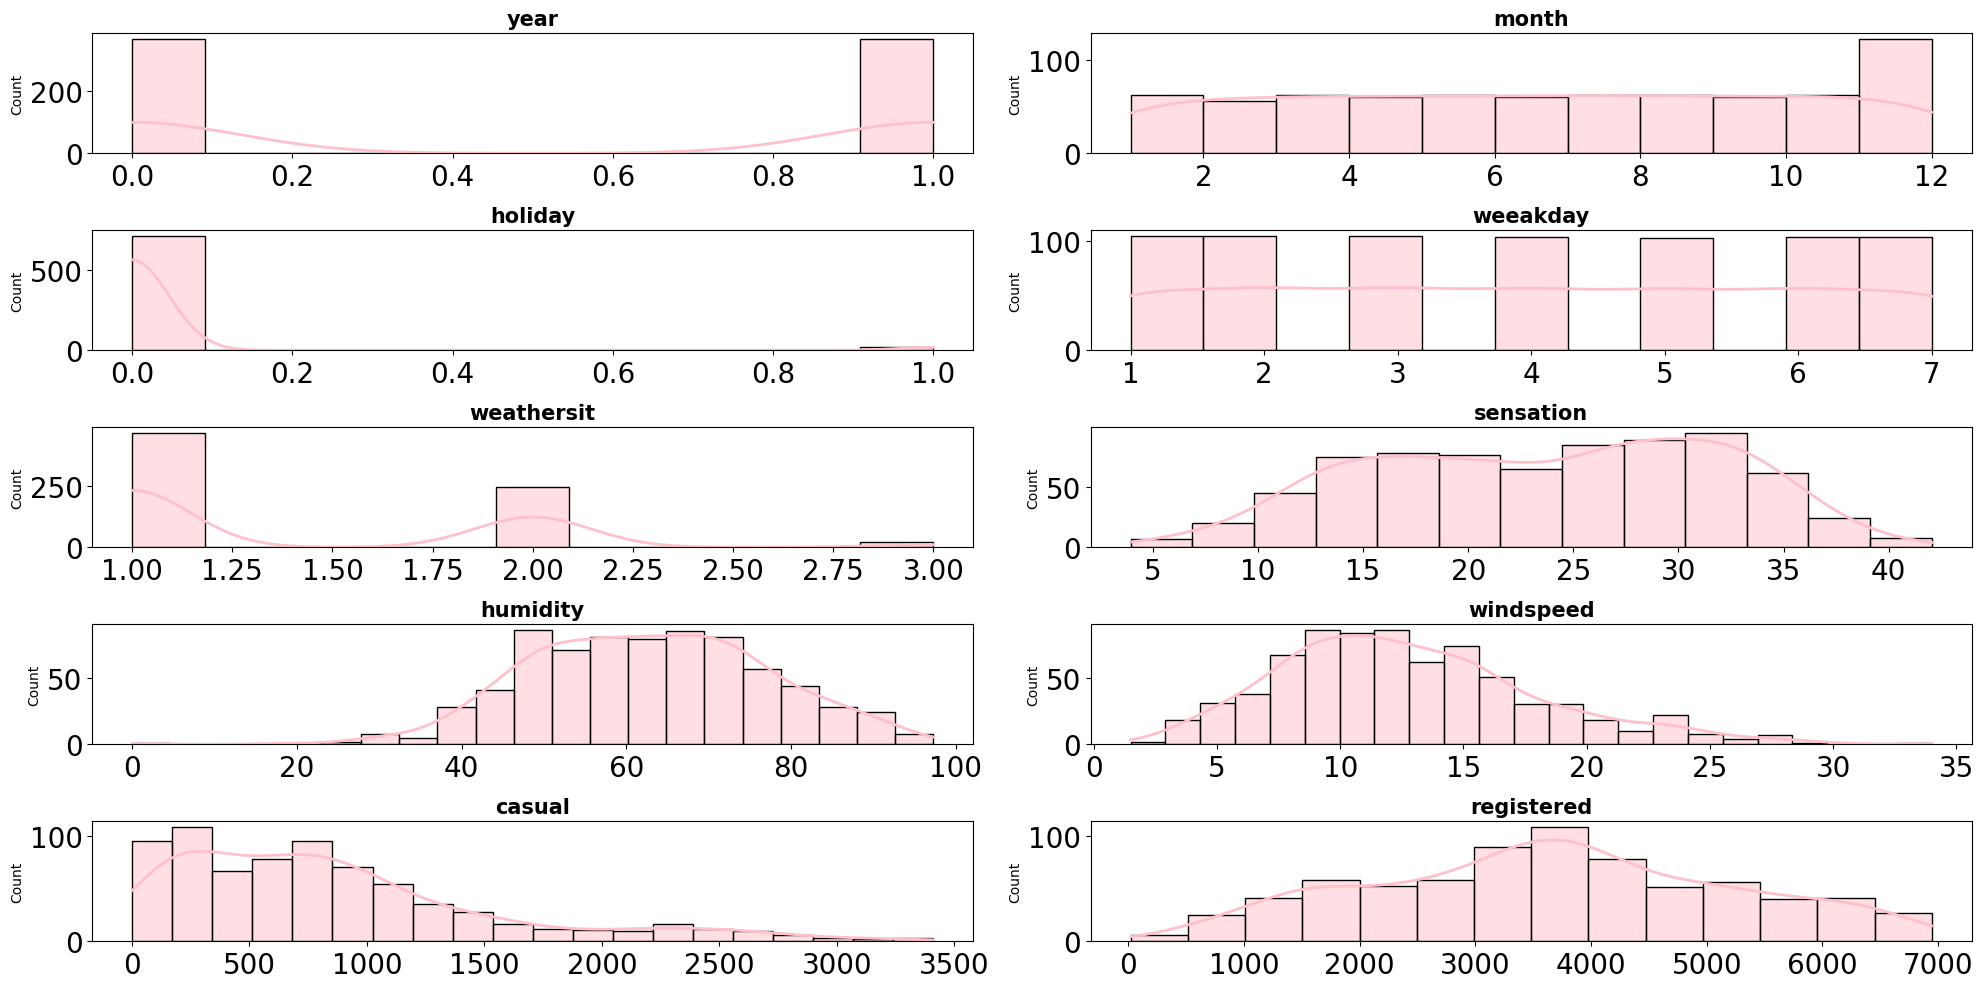

In [5]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (20,10))
axes = axes.flat
columnas_numeric = df.select_dtypes(include = [np.number, "category"]).columns
columnas_numeric = columnas_numeric.drop(["count"])

for i, colum in enumerate(columnas_numeric): 
    sns.histplot(
        data = df,
        x = colum,
        kde = True, 
        color = "pink", 
        line_kws = {"linewidth": 2},
        alpha = 0.5, 
        ax = axes[i])
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")

fig.tight_layout()

Como podemos observar nuestras variables respuesta se comportan como una variable categorica, esto se debe a que algunas (year, holiday y weathersit) vienen con un encoding, pero viendo estoy resultados podemos ver que tenemos que hacer un encoding distinto ya que de no hacerlo le dariamos más peso (importancia) a valores que no queremos darle ese peso. Pero veamos como se comportan nuestras variables con respecto a nuestra variable respuesta.

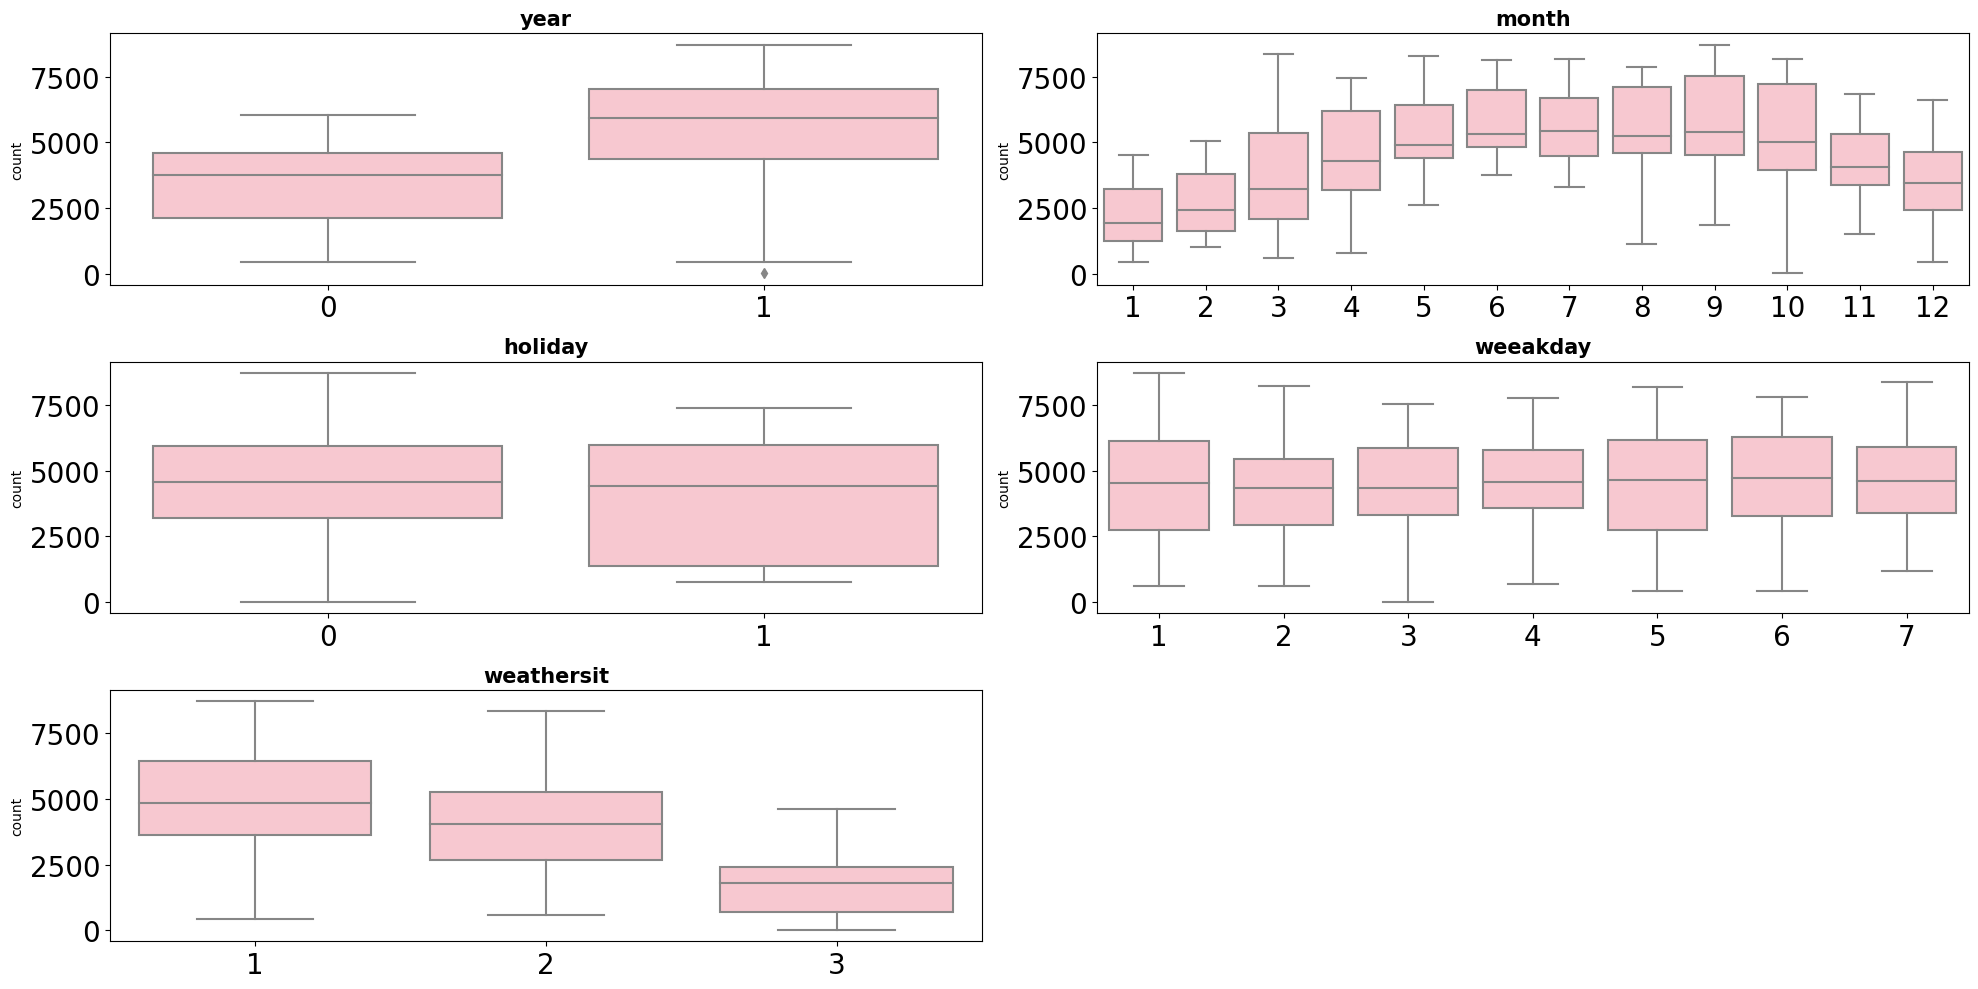

In [6]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20,10))
axes = axes.flat
columnas_numeric = df.select_dtypes(include = [np.number, "category"]).columns
columnas_numeric = columnas_numeric.drop(["count","sensation", "humidity", "windspeed", "casual", "registered"])

for i, colum in enumerate(columnas_numeric): 
    sns.boxplot(
        data = df,
        y = "count",
        x=colum,
        color = "pink", 
        ax = axes[i])
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")

fig.tight_layout()
fig.delaxes(axes[-1])

Resultados:
- Year: En este caso podemos ver que si tiene una variación en su mediana por lo que hay que realizarle un encoding a esta variable.

- Month: Como podemos ver las mediana se comportan muy distinto entre cada mes, así que hay que codificarlos de manera distinta. Por ejemplo diciembre tiene un peso de 12 (por ser el mes 12) pero no es el mes con más actividad de los usuarios, por lo que hay que cambiar esto.
- Holiday: En esta variable no tenemos ninguna variación de medianas.
- Weeakday: En este caso no hay diferencia entre los días de la semana, lo cual es sorpresa ya que creiamos que los fines de semana si se comportarían distinto.
- Weathersit:En esta variable vemos que los pesos están invertidos por lo que hay que codificarlo al reves.

#### Correlación entre variables numéricas

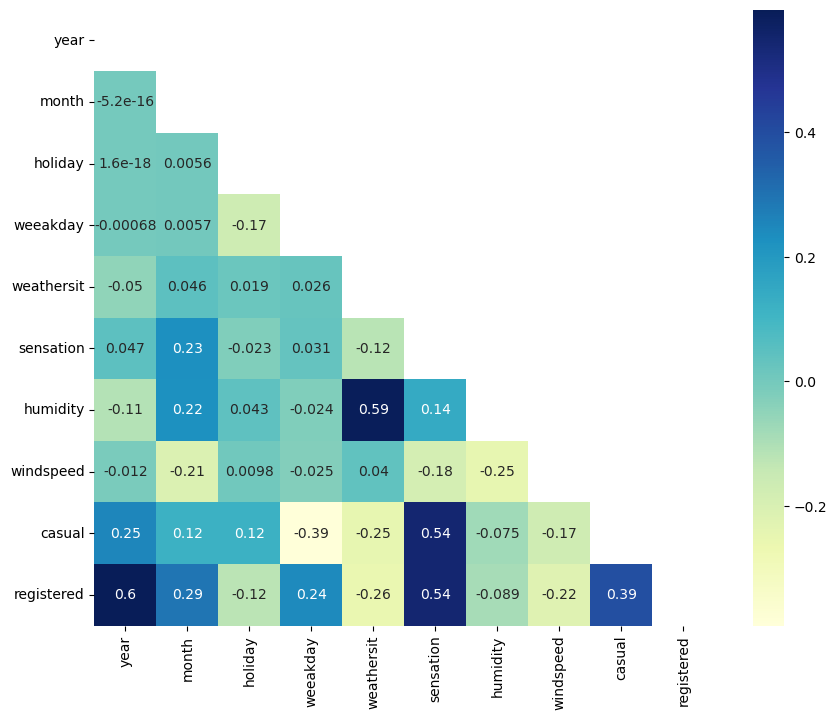

In [7]:
numericas=df.select_dtypes(include = np.number).drop(["count"], axis=1)

# creamos un dataframe todo de unos de la misma forma que nuestra matriz de correlación
mask = np.triu(np.ones_like(numericas.corr(), dtype = np.bool))

sns.heatmap(numericas.corr(), 
           cmap = "YlGnBu", 
            mask = mask,
            #v_min=-1,
            #v_max=1,
           annot = True);


Podemos observar que tenemos una correlación muy alta entre year, holiday y month. Así mismo tenemos una correlación alta entre sensation, casual y registered.

# Estandarización

In [8]:
numericas.drop(["weeakday", "weathersit","month","holiday","year"], axis = 1, inplace = True)
numericas.head(2)

,sensation,humidity,windspeed,casual,registered
0,18.18125,80.5833,10.749882,331,654
1,17.68695,69.6087,16.652113,131,670


In [9]:
# construir el modelo de escalador
robust = RobustScaler()

# ajustamos el modelo utilizando nuestro set de datos
robust.fit(numericas)

# transformamos los datos
X_robust = robust.transform(numericas)
# por último convertiremos el array que nos devuelve en un dataframe. 

numericas_robust = pd.DataFrame(X_robust, columns = numericas.columns)
df[numericas_robust.columns] = numericas_robust
df.head()

,season,year,month,holiday,weeakday,weathersit,sensation,humidity,windspeed,casual,registered,count
0,winter,0,1,1,1,2,-0.456399,0.855582,-0.208909,-0.494713,-1.319816,985
1,winter,0,1,0,2,2,-0.492863,0.332722,0.687550,-0.751041,-1.312801,801
2,winter,0,1,0,3,1,-1.098990,-0.900337,0.685210,-0.765139,-1.067733,1349
3,winter,0,1,0,4,1,-1.015201,-0.170632,-0.210435,-0.780519,-0.969093,1562
4,winter,0,1,0,5,1,-0.951952,-0.901843,0.060294,-0.813842,-0.941035,1600


# Encoding

In [10]:
df.reset_index(drop=True, inplace=True)

## le daremos los números más altos a aquellas categorías que sean más importantes, en este caso, al clima bueno
mapa = {3:1,2:2,1:3} 
df["weathersit_map"] = df["weathersit"].map(mapa)

# Columna año
mapa_año={0:1,1:2}
df["year_map"] = df["year"].map(mapa_año)

mapa_season={"winter":1,"autumn":2,"spring":3,"summer":3}
df["season_map"] = df["season"].map(mapa_season)

#columna day
mapa_dia={1:1, 2:2, 3:1, 4:1, 5:2, 6:1, 7:2}
df["weeakday_map"] = df["weeakday"].map(mapa_dia)

Vamos a eliminar las columnas que no vamos a ocupar para nuestro modelo.
Nota: 
Se hicieron pruebas con las diversas columnas, en diferentes combinaciones y nos quedamos con las que afectaban de manera más significativa a nuestra variable así como las que nos dieron los mejores resultados.

In [11]:
df.drop(["season","weeakday","month","registered","holiday","weathersit","weeakday_map","humidity","casual","year"], axis=1, inplace=True)
df.head(2)

,sensation,windspeed,count,weathersit_map,year_map,season_map
0,-0.456399,-0.208909,985,2,1,1
1,-0.492863,0.687550,801,2,1,1


## 🌳🌳 DECISION TREE 🌳🌳

Vamos a proceder a realizar el módelo.

In [12]:
# al igual que en la regresión lineal tenemos que separar nuestro dataframe en X e y
X = df.drop(["count"], axis = 1)
y = df["count"]
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

In [13]:
# max features. Como vemos, debemos poner en nuestro modelo una profudidad máxima de 3.
max_features = np.sqrt(len(x_train.columns))
max_features

2.23606797749979

In [14]:
# max depth
print(arbol.tree_.max_depth)

18


In [15]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [16]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [17]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,670.575342,871277.136986,933.422272,0.745452,test,Decission Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decission Tree I


In [18]:
param = {"max_depth": [1,2,3,4,5,6,7,8,9],
        "max_features": [1,2,3,4],
        "min_samples_split": [20, 50, 100],
        "min_samples_leaf": [20, 50, 100]} 

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param, 
            cv=10,  
            verbose=-1,
            return_train_score = True,
            scoring="neg_mean_squared_error") 

In [19]:
# ajustamos el modelo que acabamos de definir en el GridSearch
gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [20, 50, 100],
                         'min_samples_split': [20, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [20]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=7, max_features=4, min_samples_leaf=20,
                      min_samples_split=20)

In [21]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,618.495193,686195.818826,828.369373,0.799525,test,Decision tree II
1,644.127301,771534.295342,878.370250,0.797800,train,Decision tree II


In [22]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,670.575342,871277.136986,933.422272,0.745452,test,Decission Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decission Tree I
0,618.495193,686195.818826,828.369373,0.799525,test,Decision tree II
1,644.127301,771534.295342,878.370250,0.797800,train,Decision tree II


Como podemos obbservar nuestras métricas no son para nada buenas, pero son las mejores que se han logrado conseguir. Vamos a realizar otro método llamado ramdom forest para ver si conseguimos mejores resultados.

In [23]:
# vamos a crearnos un dataframe 
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )
# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)
# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
4,season_map,0.405744
3,year_map,0.384214
0,sensation,0.182248
2,weathersit_map,0.017425
1,windspeed,0.010369


En cuanto a la importancia de nuestras variables podemos ver que en mayor o menor medida relevancia para nuestra variable respuesta.

## 🌳🌲🌳🌱🌳 RANDOM FOREST 🌳🌲🌳🌱🌳

Vamos a probar ahora con el módelo Random Forest para ver si conseguimos mejores resultados.

In [24]:
Xs = df.drop(["count"], axis = 1)
ys = df["count"]

In [26]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo
x_train, x_test, y_train, y_test = train_test_split(Xs, ys, test_size = 0.2, random_state = 42)

param = {"max_depth": [1,2,3,4,5,6,7,8,9], 
        "max_features": [1,2,3],
        "min_samples_split": [20, 50, 100],
        "min_samples_leaf": [20, 50, 100]} 

gs_rf = GridSearchCV(
            estimator=RandomForestRegressor(), 
            param_grid= param, 
            cv=10, 
            verbose=-1, 
            return_train_score = True,
            scoring="neg_mean_squared_error")

# 🚨 Esta celda puede tardar en ejecutarse
gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': [1, 2, 3],
                         'min_samples_leaf': [20, 50, 100],
                         'min_samples_split': [20, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [96]:
bosque = gs_rf.best_estimator_
bosque

RandomForestRegressor(max_depth=5, max_features=3, min_samples_leaf=20,
                      min_samples_split=20)

In [97]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

In [98]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [99]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest")
dt_results

,MAE,MSE,RMSE,R2,set,modelo
0,600.420818,612142.384066,782.395286,0.821160,test,Random Forest
1,618.924328,691863.763926,831.783484,0.818679,train,Random Forest


Bueno tenemos mejores métricas pero todavía son muy altas vamos a ver la importancia de nuestras variables.

In [100]:
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': bosque.feature_importances_}
                            )

# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,sensation,0.456350
3,year_map,0.333053
4,season_map,0.166380
2,weathersit_map,0.028467
1,windspeed,0.015750


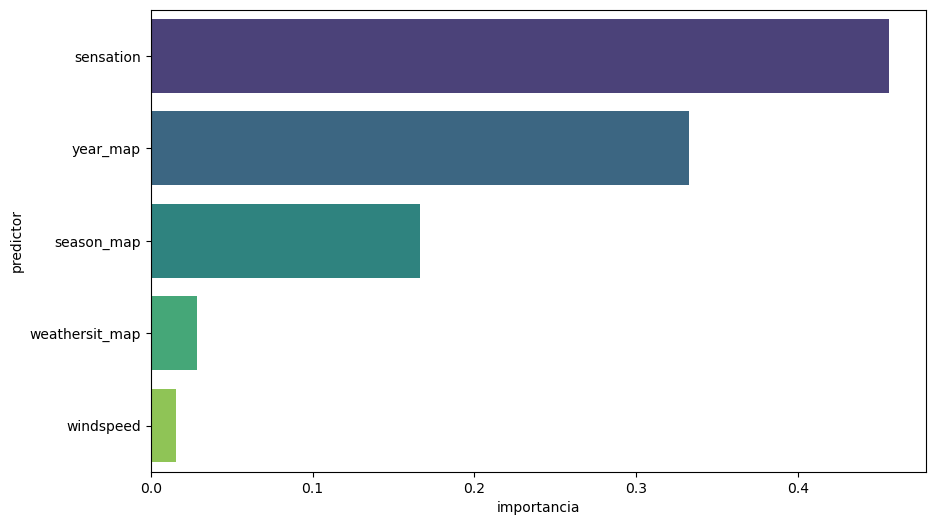

In [101]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

Como podemos ver la variable Sensacion termica es que la que tiene más relevancia lo cual tiene sentido ya que el clima y la temperatura jugarán un papel fundamental para que un cliente ya sea casual o registrado decida coger una bicicleta o no.

Como nuestros resultados no son los esperados hemos decidido hacer más pruebas con más modelos cambiando la variable respuesta y las variables predictoras. Lo veremos en los siguientes jupyters.